<a href="https://colab.research.google.com/github/jaircampfens/Paper-Dynamic-Bayesian-Networks-/blob/main/Model_Analysis_Exponential_decay_function.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Betas 2025–2033: {'IF': 0.482, 'PV': 0.473, 'EN': 0.491}
Betas 2033–2040: {'IF': 0.7420000000000001, 'PV': 0.624, 'EN': 0.571}
Betas 2040+     : {'IF': 0.5609999999999999, 'PV': 0.5609999999999999, 'EN': 0.653}


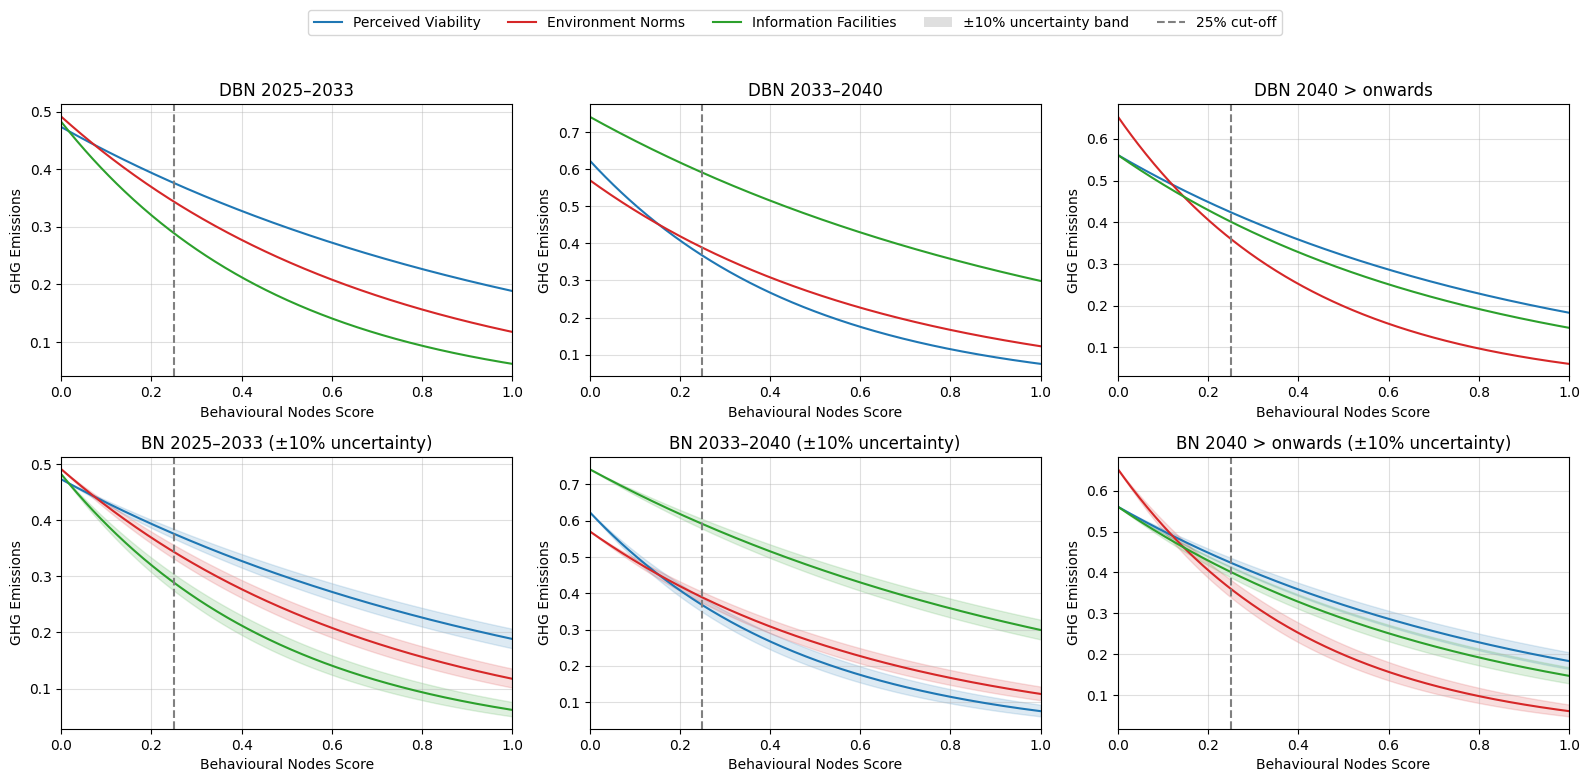

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# ============================================
# 1. Probabilities per timeframe (from DBN)
# ============================================

probs_t1 = {  # 2025–2033
    "IF": (0.26, 0.24, 0.51),
    "PV": (0.24, 0.27, 0.49),
    "EN": (0.21, 0.41, 0.38),
}

probs_t2 = {  # 2033–2040
    "IF": (0.55, 0.34, 0.11),
    "PV": (0.41, 0.32, 0.27),
    "EN": (0.34, 0.33, 0.33),
}

probs_t3 = {  # 2040 onwards
    "IF": (0.33, 0.33, 0.33),
    "PV": (0.33, 0.33, 0.33),
    "EN": (0.42, 0.39, 0.19),
}

def compute_beta(p_high, p_med, p_low):
    """β = 1.0·P_high + 0.5·P_medium + 0.2·P_low"""
    return 1.0 * p_high + 0.5 * p_med + 0.2 * p_low

def betas_from_probs(prob_dict):
    return {k: compute_beta(*v) for k, v in prob_dict.items()}

betas_t1 = betas_from_probs(probs_t1)
betas_t2 = betas_from_probs(probs_t2)
betas_t3 = betas_from_probs(probs_t3)

print("Betas 2025–2033:", betas_t1)
print("Betas 2033–2040:", betas_t2)
print("Betas 2040+     :", betas_t3)

# ===================================================================
# 2. Lambda values (learned from GeNIe with non-linear curve fitting)
# https://support.bayesfusion.com/docs/GeNIe/learningmetalog.html

# ===================================================================

# 2025-2033
lambdas_t1 = {
    "IF": 2.05,
    "EN": 1.43,
    "PV": 0.92,
}

# 2033–2040
lambdas_t2 = {
    "PV": 2.12,
    "EN": 1.54,
    "IF": 0.91,
}

# 2040 onwards: EN strongest, then IF, PV weakest
lambdas_t3 = {
    "EN": 2.38,   # biggest λ
    "IF": 1.34,
    "PV": 1.12,
}

# ============================================
# 3. Plotting functions
# ============================================

node_colors = {
    "PV": "#1f77b4",   # blue
    "EN": "#d62728",   # red
    "IF": "#2ca02c",   # green
}

def decay_curve(x, beta, lam):
    return beta * np.exp(-lam * x)

def plot_panel(ax, betas, lambdas, title, show_band=False, band_fraction=0.10):
    x_vals = np.linspace(0, 1, 400)

    all_y = []

    for node in ["PV", "EN", "IF"]:   # fixed order for consistent colors
        beta = betas[node]
        lam  = lambdas[node]

        y = decay_curve(x_vals, beta, lam)
        ax.plot(x_vals, y, color=node_colors[node], label=node)
        all_y.append(y)

        if show_band:
            lam_low  = lam * (1 - band_fraction)
            lam_high = lam * (1 + band_fraction)
            y_low  = decay_curve(x_vals, beta, lam_low)
            y_high = decay_curve(x_vals, beta, lam_high)
            ax.fill_between(
                x_vals, y_low, y_high,
                color=node_colors[node],
                alpha=0.15
            )
            all_y.append(y_low)
            all_y.append(y_high)

    # 25% behavioural score cut-off
    ax.axvline(x=0.25, color="gray", linestyle="--")

    # Dynamic y-limits: zoom in on where the curves actually are
    all_y = np.concatenate(all_y)
    y_min = all_y.min()
    y_max = all_y.max()
    margin = 0.05 * (y_max - y_min)
    ax.set_ylim(y_min - margin, y_max + margin)

    ax.set_xlim(0, 1)
    ax.set_title(title)
    ax.set_xlabel("Behavioural Nodes Score")
    ax.set_ylabel("GHG Emissions")
    ax.grid(True, alpha=0.4)

# ============================================
# 4. Create the 2×3 figure
# ============================================

fig, axes = plt.subplots(2, 3, figsize=(16, 8))
band_frac = 0.10
band_label = f"±{band_frac*100:.0f}% uncertainty band"

# Top row: deterministic
plot_panel(axes[0, 0], betas_t1, lambdas_t1, "DBN 2025–2033", show_band=False)
plot_panel(axes[0, 1], betas_t2, lambdas_t2, "DBN 2033–2040", show_band=False)
plot_panel(axes[0, 2], betas_t3, lambdas_t3, "DBN 2040 > onwards", show_band=False)

# Bottom row: ±10% lambda uncertainty
plot_panel(axes[1, 0], betas_t1, lambdas_t1,
           "BN 2025–2033 (±10% uncertainty)", show_band=True, band_fraction=band_frac)
plot_panel(axes[1, 1], betas_t2, lambdas_t2,
           "BN 2033–2040 (±10% uncertainty)", show_band=True, band_fraction=band_frac)
plot_panel(axes[1, 2], betas_t3, lambdas_t3,
           "BN 2040 > onwards (±10% uncertainty)", show_band=True, band_fraction=band_frac)

# ============================================
# 5. Master legend
# ============================================

handles = [
    plt.Line2D([0], [0], color=node_colors["PV"]),
    plt.Line2D([0], [0], color=node_colors["EN"]),
    plt.Line2D([0], [0], color=node_colors["IF"]),
    Patch(facecolor='gray', alpha=0.25),
    plt.Line2D([0], [0], color='gray', linestyle='--'),
]
labels = [
    "Perceived Viability",
    "Environment Norms",
    "Information Facilities",
    band_label,
    "25% cut-off",
]

fig.legend(handles, labels, loc="upper center", ncol=5, bbox_to_anchor=(0.5, 0.98))

plt.tight_layout(rect=[0, 0, 1, 0.90])
plt.show()
